In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from datetime import datetime
import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import seaborn as sns
from dateutil.relativedelta import relativedelta
from metricas import mae, mape, rmse, calculo_metricas, plot_meses

from sklearn.linear_model import Ridge
from sklearn.linear_model import RidgeCV



import warnings
warnings.simplefilter("ignore")

# Mostramos las versiones de los módulos para posibles reproducciones del código

print('Versión pandas:', pd.__version__)
print('Versión numpy:', np.__version__)
print('Versión matplotlib:', matplotlib.__version__)
print('Version statsmodels', sm.__version__)


Versión pandas: 1.0.5
Versión numpy: 1.19.5
Versión matplotlib: 3.2.2
Version statsmodels 0.12.2


In [2]:
df = pd.read_csv('Data/dataframe.csv', index_col = 0)
df.index = pd.to_datetime(df.index)
# df = df.drop(columns = ["Festivo_Regional", "Humedad_Relativa", "Precipitacion", "Radiacion", "Velocidad_Viento"])

df.loc[:, "lag_24"] = df.Spot_electricidad.shift(24)
df.loc[:, "lag_48"] = df.Spot_electricidad.shift(48)
df.loc[:, "lag_1_semana"] = df.Spot_electricidad.shift(24*7)

db = df.dropna()
X_train = db.copy()
y_train = X_train.pop('Spot_electricidad')

# Ridge

In [3]:
# Creación y entrenamiento del modelo (con búsqueda por CV del valor óptimo alpha)
# ==============================================================================
# Por defecto RidgeCV utiliza el mean squared error
modelo = RidgeCV(
            alphas          = np.logspace(-10, 5, 200),
            fit_intercept   = True,
            normalize       = True,
            store_cv_values = True
         )

_ = modelo.fit(X = X_train, y = y_train)

In [4]:
modelo.alpha_

0.00010718913192051265

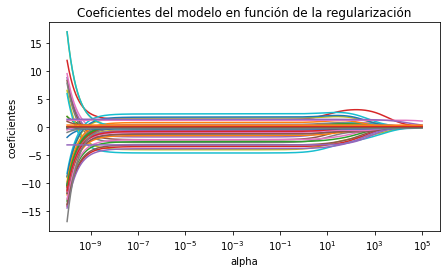

In [5]:
# Evolución de los coeficientes en función de alpha
# ==============================================================================
alphas = modelo.alphas
coefs = []

for alpha in alphas:
    modelo_temp = Ridge(alpha=alpha, fit_intercept=False, normalize=True)
    modelo_temp.fit(X_train, y_train)
    coefs.append(modelo_temp.coef_.flatten())

fig, ax = plt.subplots(figsize=(7, 3.84))
ax.plot(alphas, coefs)
ax.set_xscale('log')
ax.set_xlabel('alpha')
ax.set_ylabel('coeficientes')
ax.set_title('Coeficientes del modelo en función de la regularización');
plt.axis('tight')
plt.show()

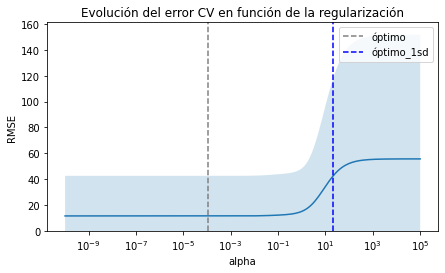

In [6]:
# Evolución del error en función de alpha
# ==============================================================================
# modelo.cv_values almacena el mse de cv para cada valor de alpha. Tiene
# dimensiones (n_samples, n_targets, n_alphas)
mse_cv = modelo.cv_values_.reshape((-1, 200)).mean(axis=0)
mse_sd = modelo.cv_values_.reshape((-1, 200)).std(axis=0)

# Se aplica la raíz cuadrada para pasar de mse a rmse
rmse_cv = np.sqrt(mse_cv)
rmse_sd = np.sqrt(mse_sd)

# Se identifica el óptimo y el óptimo + 1std
min_rmse     = np.min(rmse_cv)
sd_min_rmse  = rmse_sd[np.argmin(rmse_cv)]
min_rsme_1sd = np.max(rmse_cv[rmse_cv <= min_rmse + sd_min_rmse])
optimo       = modelo.alphas[np.argmin(rmse_cv)]
optimo_1sd   = modelo.alphas[rmse_cv == min_rsme_1sd]


# Gráfico del error +- 1 desviación estándar
fig, ax = plt.subplots(figsize=(7, 3.84))
ax.plot(modelo.alphas, rmse_cv)
ax.fill_between(
    modelo.alphas,
    rmse_cv + rmse_sd,
    rmse_cv - rmse_sd,
    alpha=0.2
)

ax.axvline(
    x         = optimo,
    c         = "gray",
    linestyle = '--',
    label     = 'óptimo'
)

ax.axvline(
    x         = optimo_1sd,
    c         = "blue",
    linestyle = '--',
    label     = 'óptimo_1sd'
)
ax.set_xscale('log')
ax.set_ylim([0,None])
ax.set_title('Evolución del error CV en función de la regularización')
ax.set_xlabel('alpha')
ax.set_ylabel('RMSE')
plt.legend();

In [7]:
# Mejor valor alpha encontrado
# ==============================================================================
print(f"Mejor valor de alpha encontrado: {modelo.alpha_}")

Mejor valor de alpha encontrado: 0.00010718913192051265


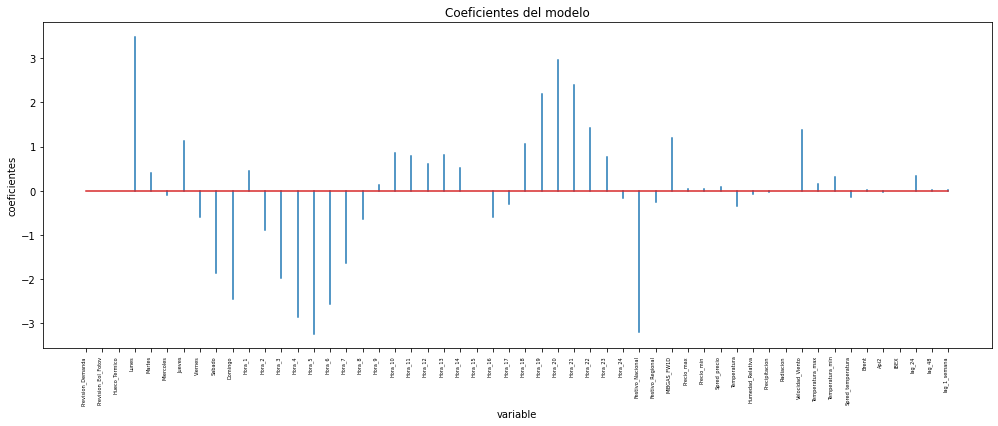

In [8]:
# Coeficientes del modelo
# ==============================================================================
df_coeficientes = pd.DataFrame(
                        {'predictor': X_train.columns,
                         'coef': modelo.coef_.flatten()}
                  )

fig, ax = plt.subplots(figsize=(17, 6))
ax.stem(df_coeficientes.predictor, df_coeficientes.coef, markerfmt=' ')
plt.xticks(rotation=90, ha='right', size=5)
ax.set_xlabel('variable')
ax.set_ylabel('coeficientes')
ax.set_title('Coeficientes del modelo');

### Backtesting

In [3]:
def bascktesting_ridge(db, año, mes, rolling_window, days_start):
    fecha = datetime(año, mes, 1)
    fecha_str = str(año) + '-' + str(mes) + '-' + str(1)
    
    db = db.dropna()
    array_real, array_pred, array_date = np.zeros(len(db.loc[fecha_str:])), np.zeros(len(db.loc[fecha_str:])), []

    # En caso de que haya rolling window
    if rolling_window == True:
        for day in range(int(len(db.loc[fecha_str:]) / 24)):
            fecha_end_train = fecha + relativedelta(days = day)
            fecha_start_train = fecha_end_train - relativedelta(days = days_start)
            fecha_end_train = str(fecha_end_train.year) + "-" + str(fecha_end_train.month) + "-" + str(fecha_end_train.day)
            fecha_start_train = str(fecha_start_train.year) + "-" + str(fecha_start_train.month) + "-" + str(fecha_start_train.day)
            db_aux = db.loc[fecha_start_train:fecha_end_train]
            
            # Dataframe de Entrenamiento
            X_train = db_aux.copy()
            y_train = X_train.pop('Spot_electricidad')
            
            # Dataframe de Test
            X_test = X_train.loc[fecha_end_train]
            y_test = y_train.pop(fecha_end_train)

            # Quitamos al dataframe de train, el dataframe de test
            X_train = X_train.drop(index = X_train.iloc[-24:].index)

            # Entrenamos el model
            model = RidgeCV(
            alphas          = np.logspace(-10, 5, 200),
            fit_intercept   = True,
            normalize       = True,
            store_cv_values = True
             )

            _ = model.fit(X = X_train, y = y_train)
            
            # Realizamos las predicciones
            pred = model.predict(X_test)
            date = X_test.index

            array_date.append(date)
            array_pred[day*24:day*24 + 24] = pred
            array_real[day*24:day*24 + 24] = y_test
    # En caso de que no haya rolling window, siempre cogemos todo el dataframe disponible
    else:
        for day in range(int(len(db.loc[fecha_str:]) / 24)):
            fecha_end_train = fecha + relativedelta(days = day)
            fecha_end_train = str(fecha_end_train.year) + "-" + str(fecha_end_train.month) + "-" + str(fecha_end_train.day)
            db_aux = db.loc[:fecha_end_train]

            # Dataframe de Entrenamiento
            X_train = db_aux.copy()
            y_train = X_train.pop('Spot_electricidad')
            
            # Dataframe de Test
            X_test = X_train.loc[fecha_end_train]
            y_test = y_train.pop(fecha_end_train)
            
            # Quitamos al dataframe de train, el dataframe de test
            X_train = X_train.drop(index = X_train.iloc[-24:].index)
            
            # Entrenamos el model
            model = RidgeCV(
            alphas          = np.logspace(-10, 5, 200),
            fit_intercept   = True,
            normalize       = True,
            store_cv_values = True
             )

            _ = model.fit(X = X_train, y = y_train)
            
            # Realizamos las predicciones
            pred = model.predict(X_test)
            date = X_test.index

            array_date.append(date)
            array_pred[day*24:day*24 + 24] = pred
            array_real[day*24:day*24 + 24] = y_test

    array_date = [item for sublist in array_date for item in sublist]
    return array_pred, array_real, array_date
    
pred, real, dates = bascktesting_ridge(db.loc["2019":], 2020, 6, rolling_window = True, days_start = 220)

### Backtesting rapido

In [11]:
for dias in [7, 14, 21, 30, 45, 60, 90 ,120, 150, 220, 365]:
    print(dias)
    print("**********************************")
    pred, real, dates = bascktesting_ridge(db.loc["2019":], 2020, 6, rolling_window = True, days_start = dias)
    resultados = pd.DataFrame({"Pred":pred, "Real":real}, index = dates)
    resultados["Pred"][resultados.loc[:, "Pred"] < 0] = 0
    calculo_metricas(resultados)

7
**********************************
     MAE  MAE (median)    MAPE  WMAPE   RMSE  % Trend
0  13.86          8.52  109.45  12.38  22.82    80.28
14
**********************************
     MAE  MAE (median)   MAPE  WMAPE   RMSE  % Trend
0  24.41          12.0  91.59  21.81  43.64     81.4
21
**********************************
     MAE  MAE (median)   MAPE  WMAPE   RMSE  % Trend
0  15.79         10.06  71.56  14.11  25.88    82.53
30
**********************************
     MAE  MAE (median)   MAPE  WMAPE   RMSE  % Trend
0  12.34          8.13  95.37  11.03  19.71    82.83
45
**********************************
     MAE  MAE (median)  MAPE  WMAPE  RMSE  % Trend
0  11.08          7.17  97.2    9.9  17.6     83.1
60
**********************************
    MAE  MAE (median)    MAPE  WMAPE   RMSE  % Trend
0  10.8          7.16  117.38   9.65  16.96     83.2
90
**********************************
     MAE  MAE (median)   MAPE  WMAPE   RMSE  % Trend
0  10.37          7.04  106.2   9.27  16.38     

### Calculo de las métricas

In [4]:
resultados = pd.DataFrame({"Pred":pred, "Real":real}, index = dates)
resultados["Pred"][resultados.loc[:, "Pred"] < 0] = 0

reg_ridge, reg_ridge_metricas_mensuales, met = calculo_metricas(resultados)

     MAE  MAE (median)    MAPE  WMAPE   RMSE  % Trend
0  10.21          6.76  122.91   9.12  16.59    83.16


In [6]:
reg_ridge.to_csv('Resultados/resultados_reg_ridge.csv')
reg_ridge_metricas_mensuales.to_csv('Resultados/resultados_mensuales_reg_ridge.csv')

In [7]:
plot_meses(reg_ridge)